In [19]:
import pickle
import tensorflow as tf
import keras
from keras import layers
from keras.utils import to_categorical
from keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load train and validation images
dataroot = "dataroot/"
train_data = pickle.load(open(dataroot+"train.p", "rb" ))
val_data = pickle.load(open(dataroot+"valid.p", "rb"))

X_train_original, y_train = train_data['features'], train_data['labels']
X_val_original, y_val = val_data['features'], val_data['labels']

In [3]:
X_train_original.shape[1:]

(32, 32, 3)

In [5]:
def resize_images(images, new_size):
    resized_images = tf.image.resize(images, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return resized_images

new_size = (128, 128)
X_train = resize_images(X_train_original, new_size).numpy()
X_val = resize_images(X_val_original, new_size).numpy()

print(X_train.shape)
print(X_val.shape)

2024-07-13 08:20:15.386014: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1710440448 exceeds 10% of free system memory.


(34799, 128, 128, 3)
(4410, 128, 128, 3)


In [6]:
my_input_shape = X_train.shape[1:]
my_input_shape

(128, 128, 3)

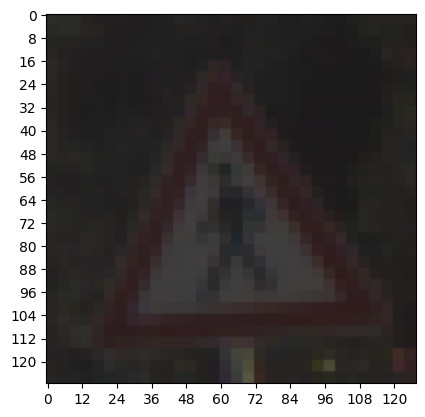

In [7]:
# upscaled image sample
random_index = np.random.randint(0, X_train.shape[0])
random_image = X_train[random_index]
plt.imshow(random_image)
plt.xticks(np.arange(0, random_image.shape[1], 12))
plt.yticks(np.arange(0, random_image.shape[1], 8))
plt.show()

In [8]:
# One-hot encode
num_classes = 43
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [14]:
def make_graphs(hist, title):
    epochs = len(hist.history['loss'])
    fig, axes = plt.subplots(2, 1, figsize=(10, 16))
    fig.suptitle(title, fontsize=16)
    make_graph_loss(hist, epochs, axes[0])
    make_graphs_accuracy(hist, epochs, axes[1])
    #make_graph_f1_score(hist, epochs, axes[1])
    #make_graph_precision(hist, epochs, axes[2])
    #make_graph_recall(hist, epochs, axes[2])
    plt.tight_layout()

def make_graph_loss(hist, epochs, ax):
    eps = [i for i in range(epochs)]
    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    sns.lineplot(x=eps, y=train_loss, color='b', label='Training Loss', ax=ax)
    sns.lineplot(x=eps, y=val_loss, color='r', label='Validation Loss', ax=ax)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training vs Validation Loss')
    ax.legend()

def make_graphs_accuracy(hist, epochs, ax):
    eps = [i for i in range(epochs)]
    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    sns.lineplot(x=eps[1:], y=train_acc[1:], color='b', label='Training Accuracy', ax=ax)
    sns.lineplot(x=eps[1:], y=val_acc[1:], color='r', label='Validation Accuracy', ax=ax)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training vs Validation Accuracy')
    ax.legend()
    

def make_graph_precision(hist, epochs, ax):
    eps = [i for i in range(epochs)]
    train_precision = hist.history['precision_4']  # Replace with your precision metric key
    val_precision = hist.history['val_precision_4']  # Replace with your validation precision metric key
    sns.lineplot(x=eps, y=train_precision, color='b', label='Training Precision', ax=ax)
    sns.lineplot(x=eps, y=val_precision, color='r', label='Validation Precision', ax=ax)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Precision')
    ax.set_title('Training vs Validation Precision')
    ax.legend()

def make_graph_recall(hist, epochs, ax):
    eps = [i for i in range(epochs)]
    train_recall = hist.history['recall']
    val_recall = hist.history['val_recall']
    sns.lineplot(x=eps, y=train_recall, color='b', label='Training Recall', ax=ax)
    sns.lineplot(x=eps, y=val_recall, color='r', label='Validation Recall', ax=ax)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Recall')
    ax.set_title('Training vs Validation Recall')
    ax.legend()

def make_graph_f1_score(hist, epochs, ax):
    eps = [i for i in range(epochs)]
    train_precision = hist.history['precision']
    train_recall = hist.history['recall']
    val_precision = hist.history['val_precision']
    val_recall = hist.history['val_recall']
    
    train_f1 = [2 * ((p * r) / (p + r + tf.keras.backend.epsilon())) for p, r in zip(train_precision, train_recall)]
    val_f1 = [2 * ((p * r) / (p + r + tf.keras.backend.epsilon())) for p, r in zip(val_precision, val_recall)]
    
    sns.lineplot(x=eps, y=train_f1, color='b', label='Training F1 Score', ax=ax)
    sns.lineplot(x=eps, y=val_f1, color='r', label='Validation F1 Score', ax=ax)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('F1 Score')
    ax.set_title('Training vs Validation F1 Score')
    ax.legend()

In [ ]:
# https://keras.io/api/applications/

In [28]:
VGG16_base = VGG16(weights='imagenet', include_top=False, input_shape=my_input_shape)
VGG16_base.trainable = False

x = VGG16_base.output
x = layers.Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

VGG16_Model = Model(inputs=VGG16_base.input, outputs=predictions)
VGG16_Model.compile(loss="categorical_crossentropy",
                    optimizer="rmsprop",
                    metrics=[Precision(name='precision'), Recall(name='recall')])

In [29]:
VGG16_hist = VGG16_Model.fit(X_train, y_train,
                       batch_size=32,
                       epochs=10,
                       validation_data=(X_val, y_val),
                       verbose=1)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 8.2577 - precision_4: 0.3671 - recall_2: 0.3142 - val_loss: 5.5994 - val_precision_4: 0.4810 - val_recall_2: 0.4227
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.7903 - precision_4: 0.7049 - recall_2: 0.6298 - val_loss: 6.1873 - val_precision_4: 0.4975 - val_recall_2: 0.4503
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.3590 - precision_4: 0.7656 - recall_2: 0.6962 - val_loss: 6.3879 - val_precision_4: 0.5200 - val_recall_2: 0.4637
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.1795 - precision_4: 0.7897 - recall_2: 0.7256 - val_loss: 6.7661 - val_precision_4: 0.4861 - val_recall_2: 0.4449
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0955 - precision_4: 0.8059 - recall_2: 0.7511 - val_loss: 7.0908 - val_precision_4: 0.4968 - val_recall_2: 0.4519
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0407 - precision_4: 0.8115 - recall_2: 0.7641 

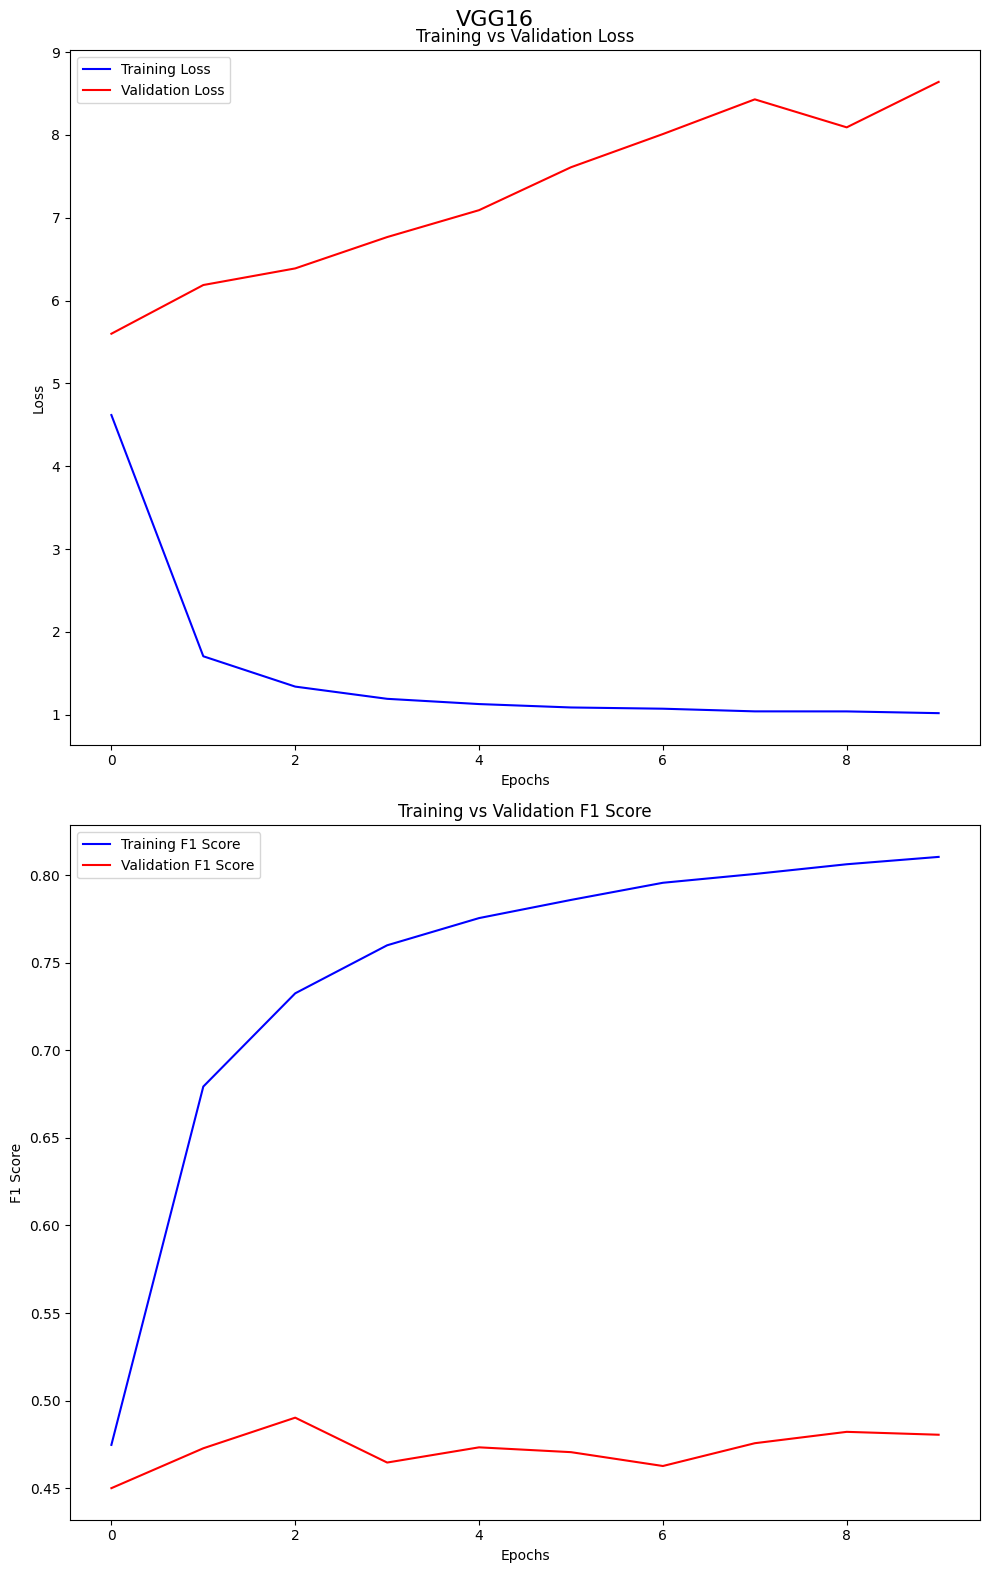

In [42]:
make_graphs(VGG16_hist, "VGG16")

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 2.1940 - precision: 0.5544 - recall: 0.3811 - val_loss: 3.3610 - val_precision: 0.4543 - val_recall: 0.3685
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.8051 - precision: 0.8023 - recall: 0.7062 - val_loss: 3.5388 - val_precision: 0.4659 - val_recall: 0.4063
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.5956 - precision: 0.8492 - recall: 0.7818 - val_loss: 3.7357 - val_precision: 0.4733 - val_recall: 0.4179
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.4958 - precision: 0.8750 - recall: 0.8242 - val_loss: 4.0680 - val_precision: 0.4618 - val_recall: 0.4138
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.4286 - precision: 0.8862 - recall: 0.8478 - val_loss: 4.1718 - val_precision: 0.4751 - val_recall: 0.4297
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.3823 - precision: 0.9036 - recall: 0.8673 - val_loss: 4.1313 - val_precision: 0.4836

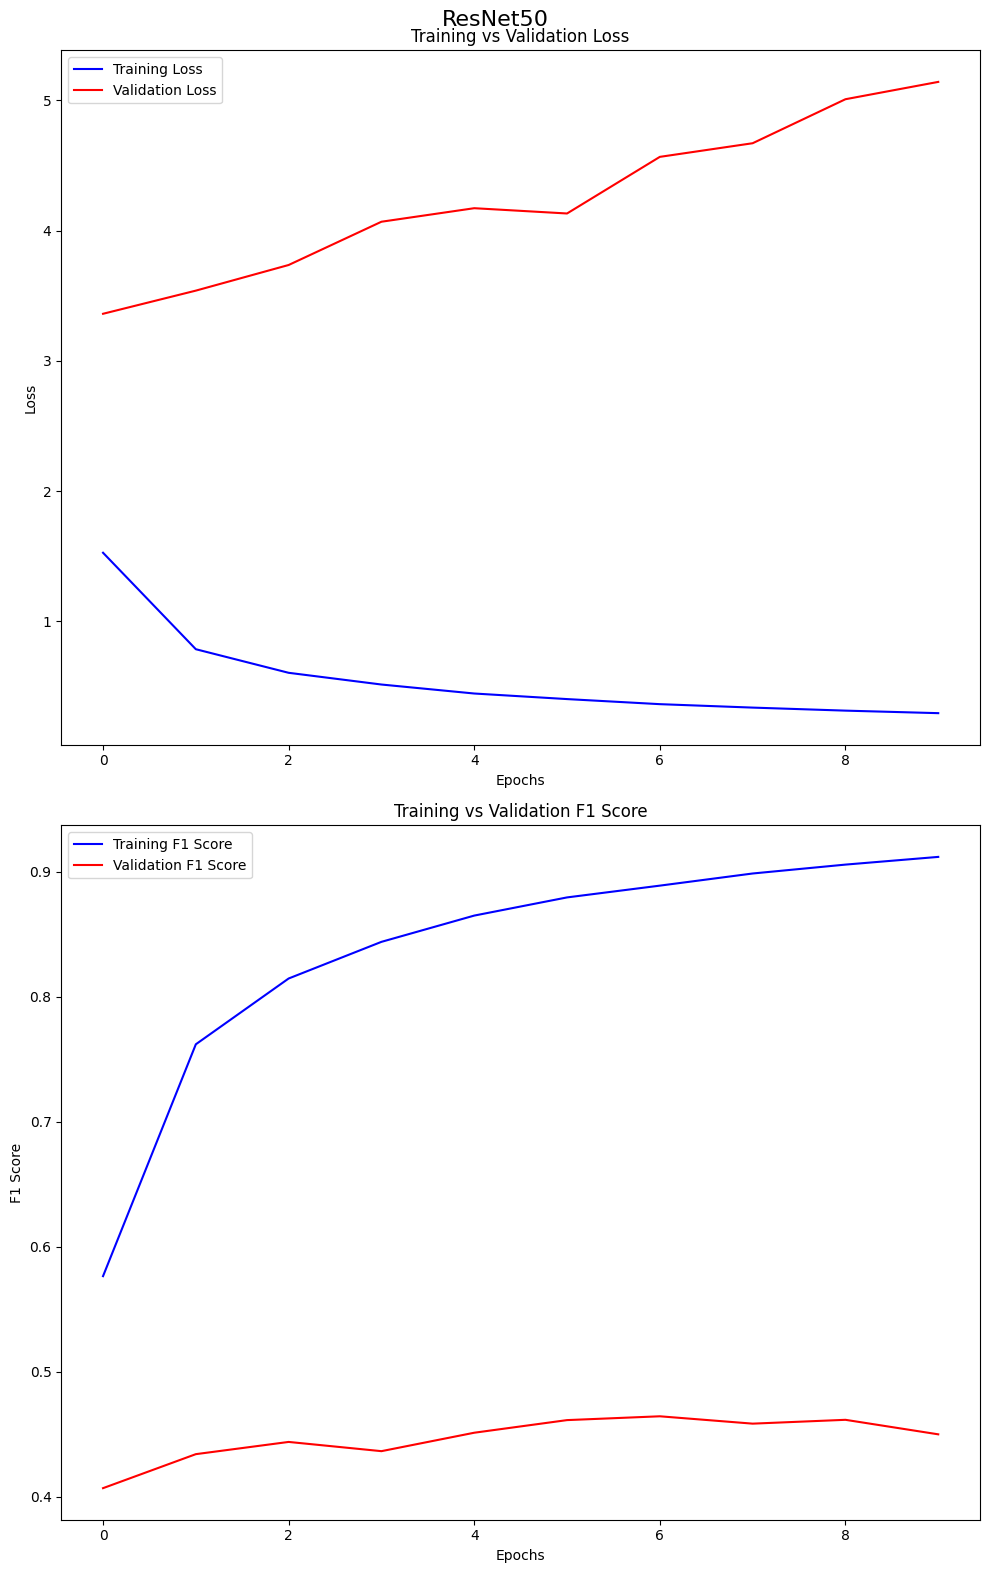

In [71]:
ResNet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=my_input_shape)
ResNet50_base.trainable = False

x = ResNet50_base.output
x = layers.Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

ResNet50_Model = Model(inputs=ResNet50_base.input, outputs=predictions)
ResNet50_Model.compile(loss="categorical_crossentropy",
                    optimizer="rmsprop",
                    metrics=[Precision(name='precision'), Recall(name='recall')])

ResNet50_hist = ResNet50_Model.fit(X_train, y_train,
                       batch_size=32,
                       epochs=10,
                       validation_data=(X_val, y_val),
                       verbose=1)

make_graphs(ResNet50_hist, "ResNet50")


In [10]:
Xception_base = Xception(weights='imagenet', include_top=False, input_shape=my_input_shape)
Xception_base.trainable = False

x = Xception_base.output
x = layers.Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

Xception_Model = Model(inputs=Xception_base.input, outputs=predictions)
Xception_Model.compile(loss="categorical_crossentropy",
                       optimizer="rmsprop",
                       metrics=["accuracy", Precision(name='precision'), Recall(name='recall')])


In [11]:
Xception_hist = Xception_Model.fit(X_train, y_train,
                                   batch_size=32,
                                   epochs=10,
                                   validation_data=(X_val, y_val),
                                   verbose=1)

Epoch 1/10


2024-07-13 08:20:56.846995: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1710440448 exceeds 10% of free system memory.


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 364s 333ms/step - accuracy: 0.2139 - loss: 81.8347 - precision: 0.2146 - recall: 0.2135 - val_accuracy: 0.2079 - val_loss: 114.7858 - val_precision: 0.2077 - val_recall: 0.2075
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 347s 319ms/step - accuracy: 0.5043 - loss: 35.2588 - precision: 0.5052 - recall: 0.5040 - val_accuracy: 0.3599 - val_loss: 84.4392 - val_precision: 0.3602 - val_recall: 0.3596
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 317s 291ms/step - accuracy: 0.6073 - loss: 25.9654 - precision: 0.6080 - recall: 0.6070 - val_accuracy: 0.3397 - val_loss: 99.0992 - val_precision: 0.3401 - val_recall: 0.3397
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 317s 292ms/step - accuracy: 0.6631 - loss: 22.0745 - precision: 0.6640 - recall: 0.6629 - val_accuracy: 0.3905 - val_loss: 95.9895 - val_precision: 0.3907 - val_recall: 0.3905
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 319s 293ms/step - accuracy: 0.7082 - loss: 18.3526 - precision: 0.7085 - recall: 0.7080 - val_ac

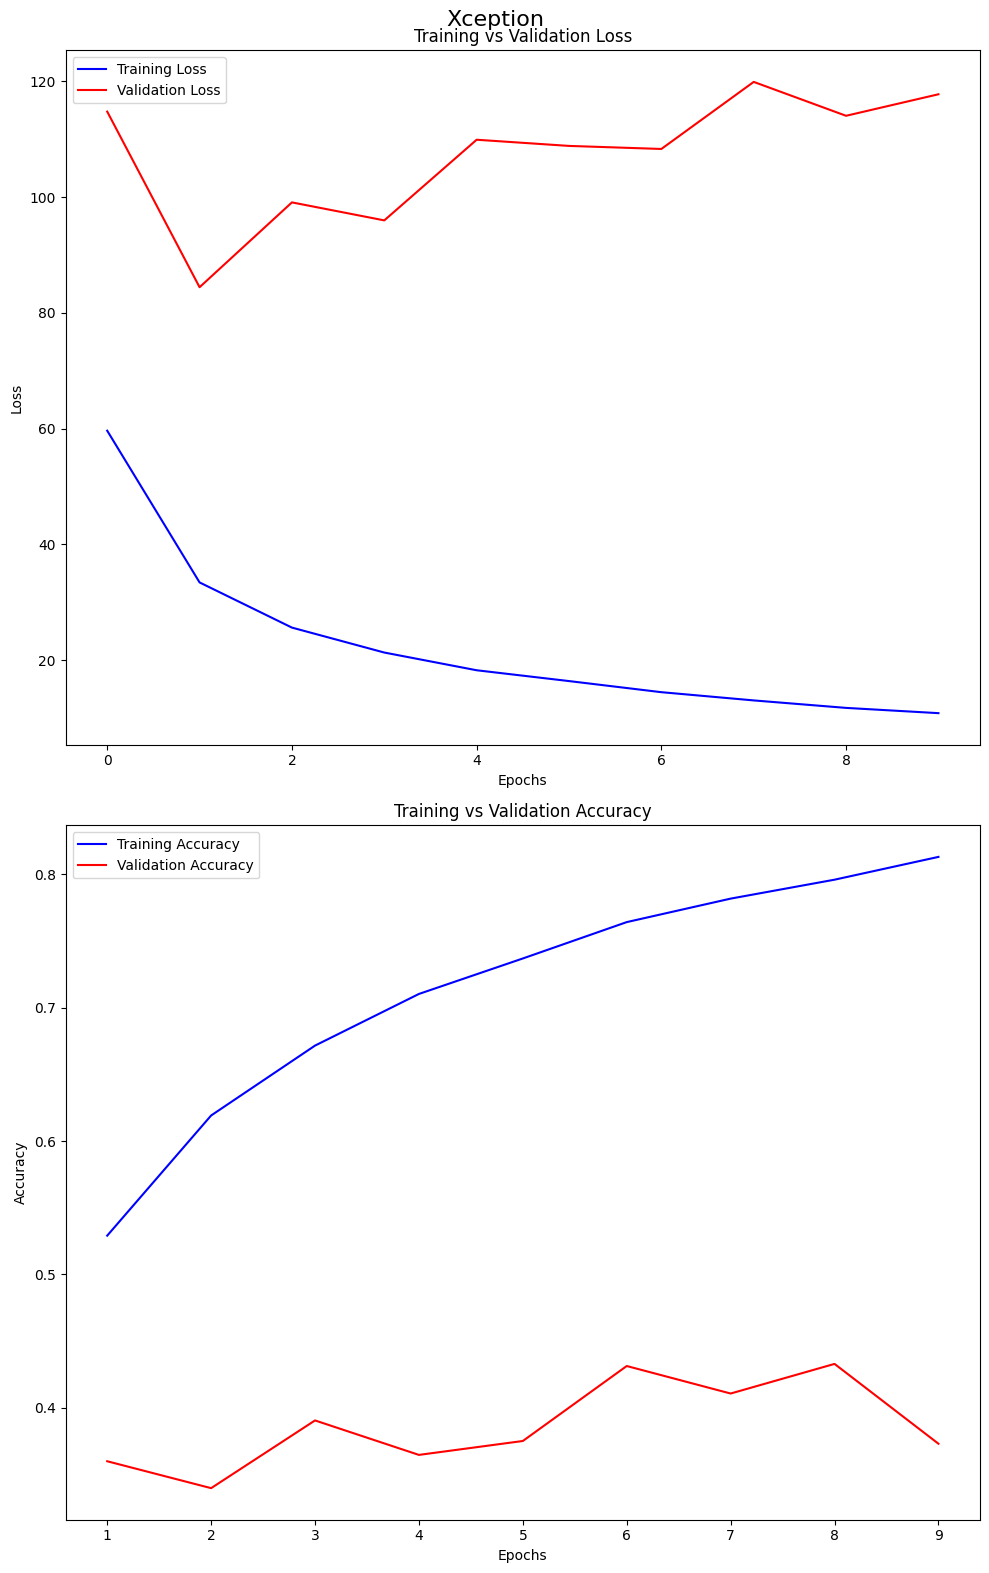

In [15]:
make_graphs(Xception_hist, "Xception")

In [17]:
MobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=my_input_shape)
MobileNetV2_base.trainable = False

x = MobileNetV2_base.output
x = layers.Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

MobileNetV2_Model = Model(inputs=MobileNetV2_base.input, outputs=predictions)
MobileNetV2_Model.compile(loss="categorical_crossentropy",
                          optimizer="rmsprop",
                          metrics=["accuracy"])

MobileNetV2_hist = MobileNetV2_Model.fit(X_train, y_train,
                                         batch_size=32,
                                         epochs=10,
                                         validation_data=(X_val, y_val),
                                         verbose=1)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


2024-07-13 09:38:49.379861: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1710440448 exceeds 10% of free system memory.


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 115s 103ms/step - accuracy: 0.3316 - loss: 6.4101 - val_accuracy: 0.3560 - val_loss: 7.7335
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 108s 99ms/step - accuracy: 0.6164 - loss: 2.5775 - val_accuracy: 0.3399 - val_loss: 8.0649
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 108s 99ms/step - accuracy: 0.7128 - loss: 1.8190 - val_accuracy: 0.4077 - val_loss: 7.0463
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 108s 99ms/step - accuracy: 0.7529 - loss: 1.5177 - val_accuracy: 0.3921 - val_loss: 9.3748
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 108s 99ms/step - accuracy: 0.7937 - loss: 1.2700 - val_accuracy: 0.3549 - val_loss: 9.9880
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 108s 99ms/step - accuracy: 0.8210 - loss: 1.0964 - val_accuracy: 0.4032 - val_loss: 8.8409
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 108s 99ms/step - accuracy: 0.8335 - loss: 0.9706 - val_accuracy: 0.4848 - val_loss: 7.4383
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 108s 99ms/step - accuracy: 0.8525 - l

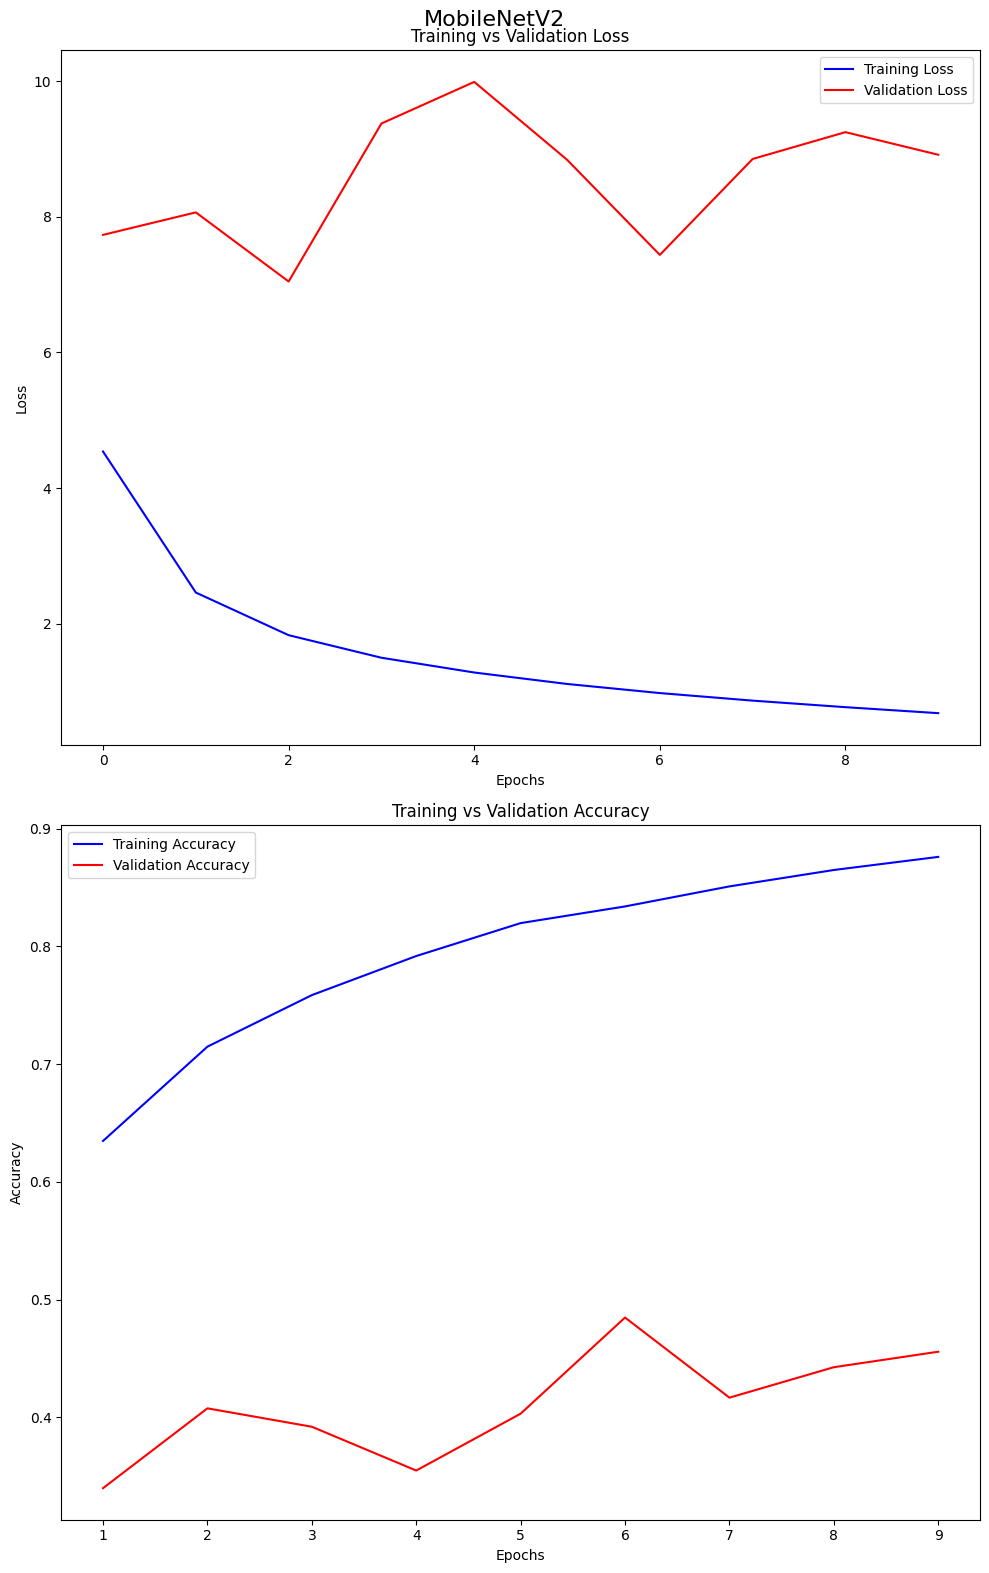

In [18]:
make_graphs(MobileNetV2_hist, "MobileNetV2")